In [1]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
%pip install efficientnet
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum
import glob
%pip install pillow
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
from collections import Counter



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

class SelectedModel(Enum):
    Eff0 = (224, 224)  # Example image size for EfficientNet 0
    Eff2 = (260, 260)  # Example image size for EfficientNet 2
    Eff4 = (380, 380)  # Example image size for EfficientNet 4
    ResNet50 = (224, 224)  # Example image size for ResNet50

    @property
    def image_size(self):
        return self.value
    def is_eff_family(self):
      return self in (SelectedModel.Eff0, SelectedModel.Eff2, SelectedModel.Eff4)


# Select the model
#my_mod = SelectedModel.ResNet50
my_mod = SelectedModel.Eff2


In [4]:
from matplotlib.layout_engine import TightLayoutEngine
# Function to display images in a grid
def display_images_in_grid(images, labels, predictions=None, confidences=None, ncols=4):
  print("Num images: "+str(len(images)))
  nrows = (len(images) + ncols -1) // ncols

  plt.figure(figsize=(15, 10))

  for i in range(len(images)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))  # Read and display the image
    title="True: "+str(labels[i])
    if predictions:
      title += "\nPredicted: "+str(predictions[i])
    if confidences:
      title += "\nConfidence: "+str(confidences[i])

    plt.title(title)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

def predict_and_display_images_in_grid(model, data_gen, num_images_to_display = 4  ):
  #print(data_gen.class_indices)
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  print(class_labels)
  predictions = []
  ground_truth_labels = []
  # plot a single image
  for x,y in data_gen:
    print("Plotting x with length "+str(len(x)))
    for i in range(len(x)):
      image = x[i]  # Get the ith image from the batch
      label_confidence=np.max(y[i])
      label_index = np.argmax(y[i])  # Get the index of the predicted class
      pred= class_labels[np.argmax(model.predict(tf.expand_dims(image, axis=0))[0])]
      predictions.append(pred)
      ground_truth_labels.append(class_labels[label_index])
      #print(y[i])
      #print(len(predictions))
      # Display the image
      plt.imshow(image)
      plt.title(f"Label: {class_labels[label_index]}\nPred: "+str(pred))
      plt.grid(False)
      plt.show()
      if(i >= num_images_to_display):
        break
    break
  print(ground_truth_labels)
  print(predictions)
  ret={}
  ret['groundtruth']=ground_truth_labels
  ret['predictions']=predictions
  return ret
def show_confusion_matrix(truth, pred, title):
  print("Showing Confusion Matrix")
  print(len(truth))
  print(len(pred))
  accuracy = accuracy_score(truth, pred)
  print("Accuracy: {:.2%}".format(accuracy))

  conf_matrix = confusion_matrix(truth, pred)

  # Create a heatmap to visualize the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  plt.show()


def plot_sample_from_filenames(df):
  # Randomly select 16 indices from your DataFrame
  sample_indices = random.sample(range(len(df)), 16)

  # Create a subplot with 4 rows and 4 columns to display the images
  plt.figure(figsize=(10, 10))
  for i, idx in enumerate(sample_indices):
    image_path = df['filename'].iloc[idx]
    label = df['class'].iloc[idx]

    ax = plt.subplot(4, 4, i + 1)
    img = plt.imread(image_path)

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

  plt.show()

def plot_class_counts(df, xname):
  # Create a count plot using Seaborn
  plt.figure(figsize=(8, 6))
  sns.set(style='whitegrid')  # Set the style

  # Create the count plot
  sns.countplot(data=df, x=xname)

  # Set plot labels and title
  plt.xlabel(xname)
  plt.ylabel('Count')
  plt.title('Count of Each Class')

  # Show the plot
  plt.show()


# Define a custom function to filter out file paths containing "mask"
def filter_mask_images(image_paths, labels):
    filtered_paths, filtered_labels = [], []
    for path, label in zip(image_paths, labels):
        if "mask" not in os.path.basename(path):  # Check if "mask" is not in the filename
            filtered_paths.append(path)
            filtered_labels.append(label)
    return np.array(filtered_paths), np.array(filtered_labels)





In [5]:
fake_data = 0
top_dropout_rate = 0.2

# Define the directory where your images are stored
base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT'
if fake_data == 1:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake'
elif fake_data == 2:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake2'


# Define your image dimensions and batch size
image_size = my_mod.image_size
batch_size = 32

# Create an ImageDataGenerator for reading and preprocessing the images
# Normalize the intensitities to [0,1]
image_generator_unfiltered = ImageDataGenerator(rescale=1./255)

unfiltered_data_generator = image_generator_unfiltered.flow_from_directory(
    base_directory,
    target_size=image_size,  # Set the target image size
    batch_size=batch_size,
    class_mode='categorical',  # For multiple classes, use 'categorical'
    shuffle=False  # set this to False if you want to preserve the order
)

# Load the image file paths and labels
print(unfiltered_data_generator.classes  )



Found 780 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [6]:
class_labels = {value: key for key, value in unfiltered_data_generator.class_indices.items()}


In [7]:
num_classes = 3

base_model = None

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(image_size[0], image_size[1]),
  layers.Rescaling(1./255)
])

if True:
  if my_mod is SelectedModel.Eff0:
    base_model= EfficientNetB0(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff2:
    base_model= EfficientNetB2(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff4:
    base_model= EfficientNetB4(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))
  elif my_mod is SelectedModel.ResNet50:
      base_model = ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(image_size[0], image_size[1], 3))
  else:
    print("Unexpected model type "+str(my_mod))
    exit()

model = tf.keras.Sequential([
    resize_and_rescale,
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(top_dropout_rate, name="top_dropout"),
    layers.Dense(num_classes, activation='softmax')
])

# Specify the input shape for the first layer
model.build(input_shape=(batch_size, image_size[0], image_size[1], 3))
#  x = base_model.output
#  x = GlobalAveragePooling2D()(x)
#  x = tf.keras.layers.BatchNormalization()(x)
#  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#  x = Dense(num_classes, activation='softmax')(x)

#model = Model(inputs=base_model.input, outputs=x)
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001),  # You can adjust the learning rate
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()




31936256/31936256 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 260, 260, 3)         0         
                                                                 
 random_flip (RandomFlip)    (32, 260, 260, 3)         0         
                                                                 
 random_rotation (RandomRot  (32, 260, 260, 3)         0         
 ation)                                                          
                                                                 
 random_contrast (RandomCon  (32, 260, 260, 3)         0         
 trast)                                                          
                                                                 
 random_zoom (RandomZoom)    (32, 260, 260, 3)         0         
                                                                 
 efficientnet-b2 (Functiona  (None, 9, 9, 1408)       

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:

# Define a ModelCheckpoint callback to save the best model during training
best_model = './drive/MyDrive/ML/BreastCancerProject/savedmodels/best_model'+str(image_size[0])+'.h5'

model.load_weights(best_model)


In [10]:
def eval_ds(gen, model, num_classes):
  metrics = model.evaluate(gen)
  print(model.metrics_names)
  print(metrics)

print("Unfiltered ")
eval_ds(unfiltered_data_generator, model,num_classes)


Unfiltered 
25/25 [==============================] - 274s 11s/step - loss: 0.0948 - accuracy: 0.9718
['loss', 'accuracy']
[0.09479349851608276, 0.971794843673706]


{0: 'benign', 1: 'malignant', 2: 'normal'}
Plotting x with length 32
1/1 [==============================] - 2s 2s/step


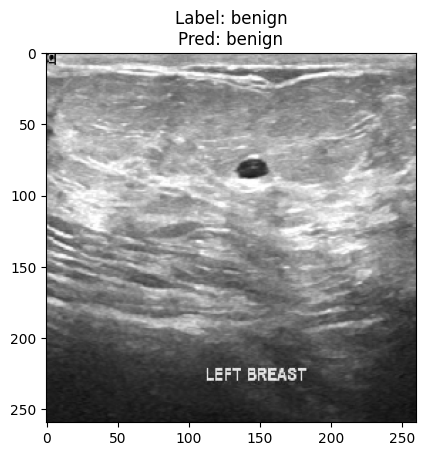

1/1 [==============================] - 0s 31ms/step


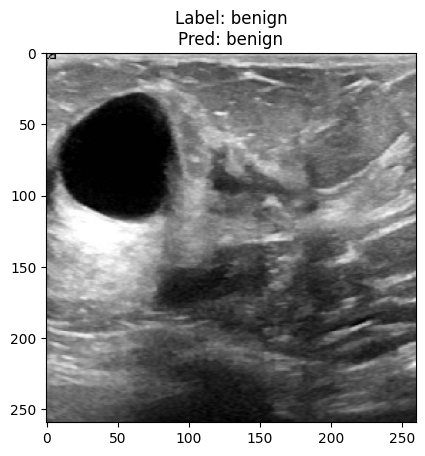

1/1 [==============================] - 0s 49ms/step


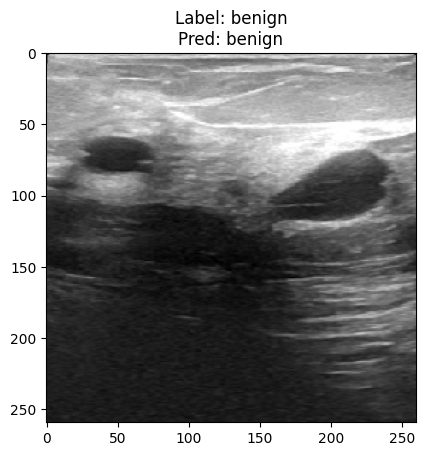

1/1 [==============================] - 0s 49ms/step


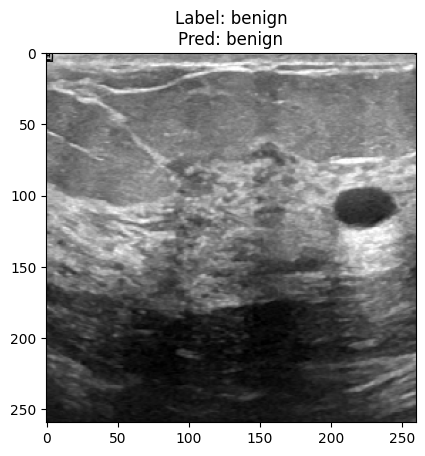

1/1 [==============================] - 0s 54ms/step


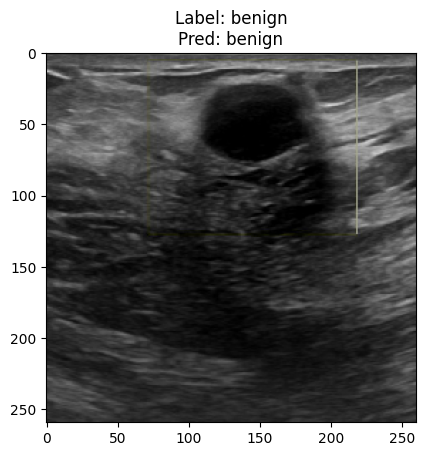

['benign', 'benign', 'benign', 'benign', 'benign']
['benign', 'benign', 'benign', 'benign', 'benign']
5
5


In [11]:
results=predict_and_display_images_in_grid(model, unfiltered_data_generator)
ground_truth_labels=results['groundtruth']
predicted_labels=results['predictions']
print(len(ground_truth_labels))
print(len(predicted_labels))

In [12]:
%pip install shap
import shap
# Assuming 'model' is your Keras model
explainer_shap = shap.Explainer(model, unfiltered_data_generator)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.9 MB/s eta 0:00:00


In [13]:
%pip install lime
from lime import lime_image
import lime
from skimage.segmentation import mark_boundaries
from contextlib import redirect_stdout
explainer_lime = lime_image.LimeImageExplainer()




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2949ad9d11e8402b2bd710e58a95f3067881b1ce71ae3f9d5250310ce0bf9735
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [14]:
# Define a new model that computes gradients
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, dy.dtype) * tf.cast(x > 0, x.dtype) * dy
    return tf.nn.relu(x), grad


def grad_cam_heatmap(img):
  from tensorflow.keras.preprocessing import image

  img = image.img_to_array(img)
  img = tf.image.resize(img, (260, 260))  # Ensure the image dimensions match your model
  img = tf.expand_dims(img, axis=0)  # Add a batch dimension

  guided_model = tf.keras.models.clone_model(model)
  for layer in guided_model.layers:
    if isinstance(layer, tf.keras.layers.ReLU):
      layer.activation = guided_relu
  with tf.GradientTape() as tape:
    inputs = img
    tape.watch(inputs)
    prediction = guided_model(inputs)  # Get model prediction

  # Calculate the gradient of the predicted class with respect to the model's last convolutional layer
  last_conv_layer = guided_model.get_layer('top_conv (Conv2D)')
  grads = tape.gradient(prediction, last_conv_layer.output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # Multiply each channel in the feature map by "how important this channel is" (global average pooled gradients)
  heatmap = tf.reduce_mean(last_conv_layer.output * pooled_grads[:, tf.newaxis, tf.newaxis, :], axis=-1)
  heatmap = tf.maximum(heatmap, 0)
  heatmap /= tf.reduce_max(heatmap)

  heatmap = tf.image.resize(heatmap, (260, 260))  # Resize heatmap to match the original image size

  # Convert the heatmap to a numpy array for visualization
  heatmap = heatmap.numpy()

  # Overlay the heatmap on the original image
  plt.imshow(heatmap, cmap='viridis', alpha=0.6)
  plt.imshow(img[0], alpha=0.4)
  plt.show()



In [18]:
def summarize_explanation(prediction, truth_label, ex_mask, truth_mask):
  # Define color thresholds for red and yellow
  #red_lower = np.array([0, 0, 200])
  #red_upper = np.array([100, 100, 255])

  yellow_lower = .9 #np.array([0, 200, 200])
  yellow_upper = 1.0#np.array([100, 255, 255])

  print("Ex Mask Dimensions:", ex_mask.shape)
  min_value = np.min(ex_mask)
  max_value = np.max(ex_mask)
  print("Minimum Value in ex_mask:", min_value)
  print("Maximum Value in ex_mask:", max_value)
  print("true Mask Dimensions:", truth_mask.shape)
  min_value = np.min(truth_mask)
  max_value = np.max(truth_mask)

  print("Minimum Value in truth_mask:", min_value)
  print("Maximum Value in truth_mask:", max_value)
  # Create binary masks for red and yellow
  red_mask = ex_mask#cv2.inRange(ex_mask, red_lower, red_upper)
  yellow_mask = cv2.inRange(truth_mask, yellow_lower, yellow_upper)

  print("Red Mask Dimensions:", red_mask.shape)
  print("Yellow Mask Dimensions:", yellow_mask.shape)

  # Use the inverse of the red and yellow masks for blue and purple
  blue_mask = cv2.bitwise_not(red_mask)
  purple_mask = cv2.bitwise_not(yellow_mask)
  print("Blue Mask Dimensions:", blue_mask.shape)
  print("Purple Mask Dimensions:", purple_mask.shape)

  # Calculate the intersection area
  red_yellow_area = np.sum(np.logical_and(red_mask, yellow_mask))
  red_purple_area = np.sum(np.logical_and(red_mask, purple_mask))
  blue_yellow_area = np.sum(np.logical_and(blue_mask, yellow_mask))
  blue_purple_area = np.sum(np.logical_and(blue_mask, purple_mask))

  # Calculate the percentage of area for each color combination
  total_area = np.sum(yellow_mask)  # Assuming yellow_mask covers the entire area
  percentage_red_yellow = (red_yellow_area / total_area) * 100
  percentage_red_purple = (red_purple_area / total_area) * 100
  percentage_blue_yellow = (blue_yellow_area / total_area) * 100
  percentage_blue_purple = (blue_purple_area / total_area) * 100

  # Print the results
  print("Prediction = "+prediction)
  print("Truth ="+truth_label)
  print("Percentage of red over yellow: {:.2f}%".format(percentage_red_yellow))
  print("Percentage of red over purple: {:.2f}%".format(percentage_red_purple))
  print("Percentage of blue over yellow: {:.2f}%".format(percentage_blue_yellow))
  print("Percentage of blue over purple: {:.2f}%".format(percentage_blue_purple))
  fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # You can adjust the figure size
  axes[0,0].imshow(red_mask)
  axes[0,0].set_title("Red Mask")
  axes[0,1].imshow(yellow_mask)
  axes[0,1].set_title("Yellow Mask")
  axes[1,0].imshow(np.logical_and(red_mask, yellow_mask))
  axes[1,0].set_title("Red AND Yellow Mask")
  axes[1,1].imshow(np.logical_and(blue_mask, purple_mask))
  axes[1,1].set_title("Blue AND Purple Mask")
  #Red Positive Impact towards actual Prediction, Blue Negative Impact towards actual
  plt.tight_layout()
  # Show the 2x2 grid of images
  plt.show()

In [19]:

class ExplainType(Enum):
  SHAP=1
  LIME=2
  GRADCAM=3

def explain_images2(model, data_gen, do_shap = False, num_images_to_display = 4, type=ExplainType.LIME  ):
  #random.seed(42)
  random.seed(43)
  #print(data_gen.class_indices)
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  print(class_labels)
  predictions = []
  ground_truth_labels = []
  # plot a single image
  file_names = data_gen.filenames
  labels = data_gen.labels
  sample_indices = set(random.sample(range(len(file_names)), num_images_to_display))
  #this one is interesting, so add it.
  sample_indices.add(114)
  max_index = max(sample_indices)
  print(sample_indices)
  outer_counter=-1
  for image_name,y in zip(file_names, labels):
    outer_counter+=1
    #print(outer_counter)
    if not outer_counter in sample_indices:
      continue

    print(outer_counter)

    print("original image = ",image_name)
    image_path = base_directory+"/"+image_name
    print("original image = ",image_path)
    tmp_filename=image_name
    tmp_filename = tmp_filename[:-4] + "_mask.png"
    orig_mask = base_directory+"/../Dataset_masks/"+tmp_filename
    print("mask = ",orig_mask)
    mask_img= mpimg.imread(orig_mask)
    img= mpimg.imread(image_path)
    mask_img = cv2.resize(mask_img, image_size, interpolation=cv2.INTER_LINEAR)
    img = cv2.resize(img, image_size, interpolation=cv2.INTER_LINEAR)
    # Create a 2x2 grid of subplots



    expanded_image = tf.expand_dims(img, axis=0)
    label_index = np.argmax(y)  # Get the index of the predicted class
    pred= class_labels[np.argmax(model.predict(expanded_image)[0])]
    predictions.append(pred)
    ground_truth_labels.append(class_labels[label_index])

    if type == ExplainType.SHAP:
      shap_values=explainer_shap(expanded_image, max_evals=500)
      shap.image_plot(shap_values, -expanded_image)
    elif type == ExplainType.LIME:

      fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # You can adjust the figure size
      axes[0,0].imshow(img)
      axes[0,0].set_title("Label: "+class_labels[label_index]+"\nPred: "+str(pred))
      axes[0,1].imshow(mask_img)
      axes[0,1].set_title("Mask")
      # Specify the number of superpixels for the explanation
      num_superpixels = 100
      explanation = None
      with open('NUL', 'w') as fnull:
        with redirect_stdout(fnull):
          explanation = explainer_lime.explain_instance(img, model.predict, top_labels=3, num_features=num_superpixels)
      ex_image, ex_mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_superpixels, hide_rest=False)

      # Visualize the image with the explanation mask
      axes[1,0].imshow(ex_image)
      axes[1,0].imshow(ex_mask, alpha=0.5)
      axes[1,0].set_title("Image with Explanation\nOverlayed")

      axes[1,1].imshow(ex_mask, cmap='jet')
      axes[1,1].imshow(mask_img, alpha=0.5)
      axes[1,1].set_title("Explanation with Truth\nMask Overlayed")
      plt.tight_layout()
      # Show the 2x2 grid of images
      plt.show()
      summarize_explanation(pred, class_labels[label_index], ex_mask, mask_img)
    elif type == ExplainType.GRADCAM:
      grad_cam_heatmap(image)
    else:
      print("unexpected type"+str(type))
      exit()



In [20]:
explain_images2(model, unfiltered_data_generator, num_images_to_display=10, type=ExplainType.LIME)

Output hidden; open in https://colab.research.google.com to view.